In [1]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, RecurrentNetwork, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import TorchNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss, RMSE




In [2]:
#Download the VIX index from yahoo finance
import yfinance as yf

vix = yf.download("^VIX")

#Compute the first difference of the VIX index
vix['Adj Close'] = vix['Adj Close'].diff()
vix = vix.dropna()

#Construct Pandas dataframe with the VIX index, the Date, a time index starting from 0 and a series column to identify the series

vix = vix.reset_index()
vix['time_idx'] = vix.index
vix['series'] = 0
#Change column name
vix = vix.rename(columns={'Adj Close':'value', 'Date':'date'})
#Drop columns
vix = vix.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
vix.head()

data = vix.copy()

[*********************100%%**********************]  1 of 1 completed


In [3]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

validation_cutoff = data["time_idx"].max() - 1000
training_cutoff = validation_cutoff - max_prediction_length


context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,date,value,time_idx,series
0,1990-01-03,0.950001,0,0
1,1990-01-04,1.029999,1,0
2,1990-01-05,0.890001,2,0
3,1990-01-08,0.150000,3,0
4,1990-01-09,1.940001,4,0


<Axes: xlabel='date'>

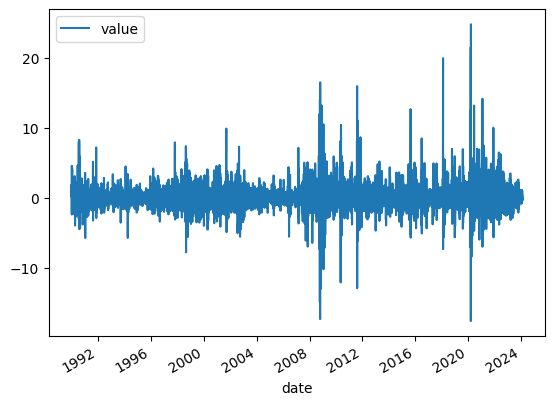

In [4]:
#plot the data value over time
data.plot(x="date", y="value")


In [5]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    group_ids=["series"],
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    target_normalizer=TorchNormalizer(),
)

validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx <= validation_cutoff], min_prediction_idx=training_cutoff + 1)
test = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=validation_cutoff + 1)

batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, shuffle=False
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, shuffle=False
)

test_dataloader = test.to_dataloader(
    train=False, batch_size=1, num_workers=0, shuffle=False
)

In [6]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\lightning_logs


tensor(1.3948)

In [7]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MAE(),
    optimizer="Adam",
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
from RecurrentNetwork_batchnorm import RecurrentNetwork_batchnorm
net = RecurrentNetwork_batchnorm.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=MAE(),
    optimizer="Adam",
)

#Do a forward pass
for i in train_dataloader:
    net(i)
    break

#Do a prediction pass
for i in val_dataloader:
    net.predict(i)
    break


({'encoder_cat': tensor([], size=(128, 100, 0), dtype=torch.int64), 'encoder_cont': tensor([[[ 0.6206],
         [ 0.6728],
         [ 0.5814],
         ...,
         [ 0.7316],
         [-0.4309],
         [ 0.3397]],

        [[ 0.6728],
         [ 0.5814],
         [ 0.0981],
         ...,
         [-0.4309],
         [ 0.3397],
         [-0.2481]],

        [[ 0.5814],
         [ 0.0981],
         [ 1.2671],
         ...,
         [ 0.3397],
         [-0.2481],
         [ 0.9340]],

        ...,

        [[ 0.4965],
         [-0.0979],
         [ 0.7446],
         ...,
         [-0.8032],
         [-0.2546],
         [-0.5616]],

        [[-0.0979],
         [ 0.7446],
         [-0.5485],
         ...,
         [-0.2546],
         [-0.5616],
         [ 0.6532]],

        [[ 0.7446],
         [-0.5485],
         [ 0.1634],
         ...,
         [-0.5616],
         [ 0.6532],
         [-0.0717]]]), 'encoder_target': tensor([[ 0.9500,  1.0300,  0.8900,  ...,  1.1200, -0.6600,  0.5200

TypeError: tuple indices must be integers or slices, not str

Finding best initial lr: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]
Learning rate set to 0.00028183829312644534
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_ba5546e0-2383-4701-a91e-a8ed4353a926.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_ba5546e0-2383-4701-a91e-a8ed4353a926.ckpt


suggested learning rate: 0.00028183829312644534


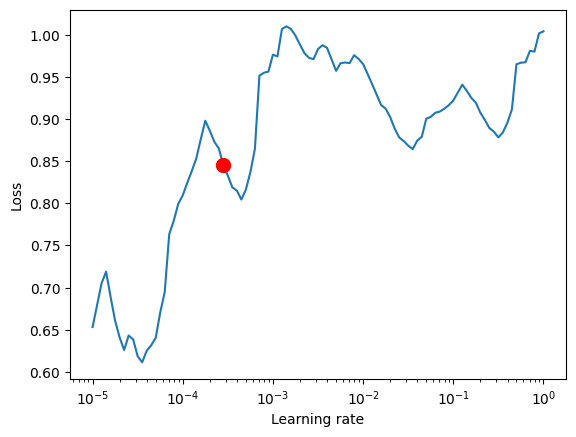

In [9]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [10]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", filename="best_model", mode="min", save_top_k=1)
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = RecurrentNetwork.from_dataset(
    training,
    cell_type="LSTM",
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MAE(), 
)

net.hparams.learning_rate = res.suggestion()

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 0     
3 | rnn              | LSTM           | 11.4 K
4 | output_projector | Linear         | 31    
----------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 50/50 [01:47<00:00,  0.46it/s, v_num=48, train_loss_step=1.310, val_loss=0.775, train_loss_epoch=0.935]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 50/50 [01:48<00:00,  0.46it/s, v_num=48, train_loss_step=1.310, val_loss=0.775, train_loss_epoch=0.935]


In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RecurrentNetwork.load_from_checkpoint(best_model_path)

In [12]:
trainer.checkpoint_callback.best_model_path

'c:\\Users\\euret\\OneDrive\\Documenti\\PhD\\Experiments\\Adaptive_Norm\\lightning_logs\\version_48\\checkpoints\\best_model.ckpt'

In [13]:
#   best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
print(MAE()(predictions.output, predictions.y))

net = best_model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.7754)


In [14]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


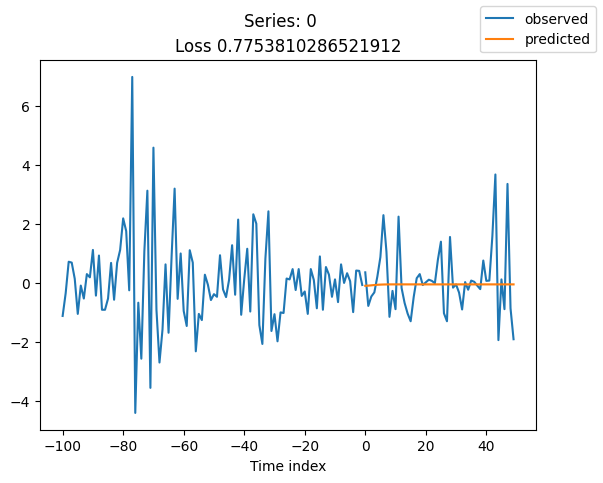

In [15]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")

In [16]:
#Test the model on the test set

predictions = best_model.predict(test_dataloader, trainer_kwargs=dict(accelerator="cpu"), mode='raw', return_index=True, return_y=True, return_x=True)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
print(MAE()(predictions.output.prediction.squeeze(), predictions.x['decoder_target']))

tensor(1.2966)


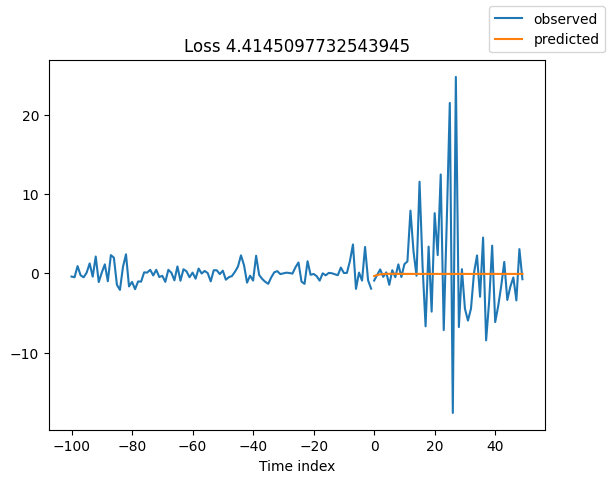

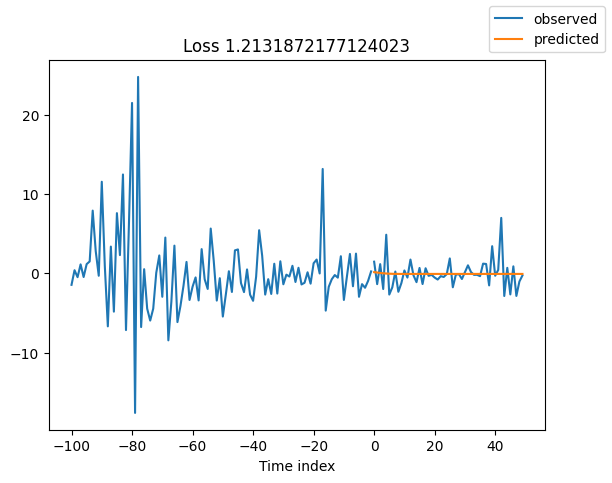

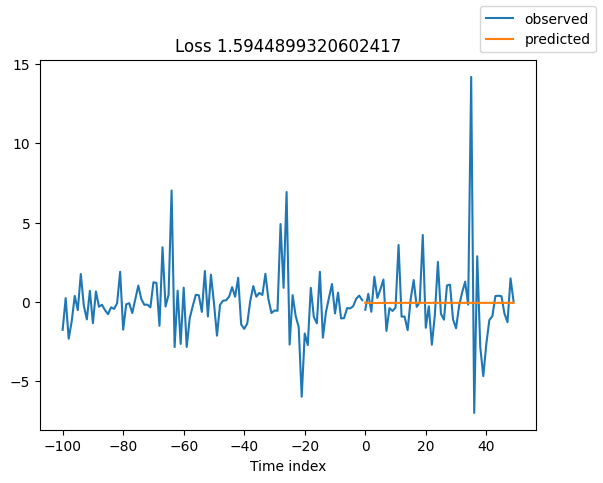

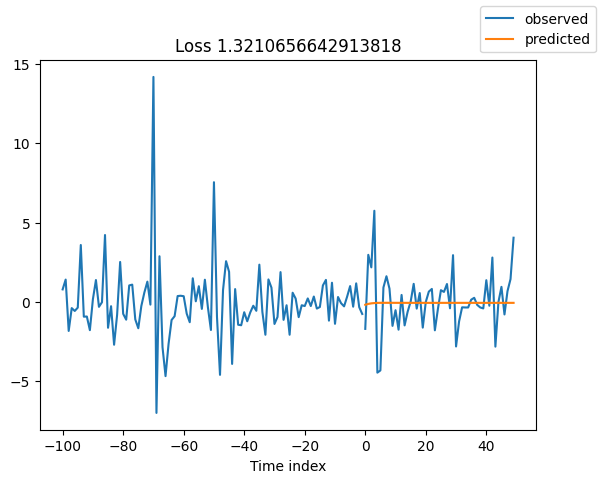

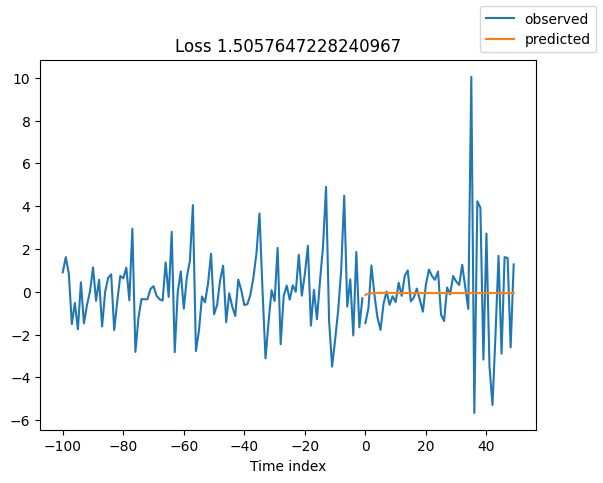

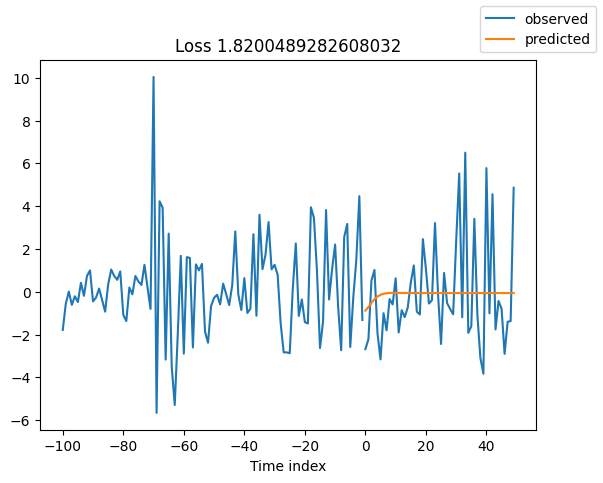

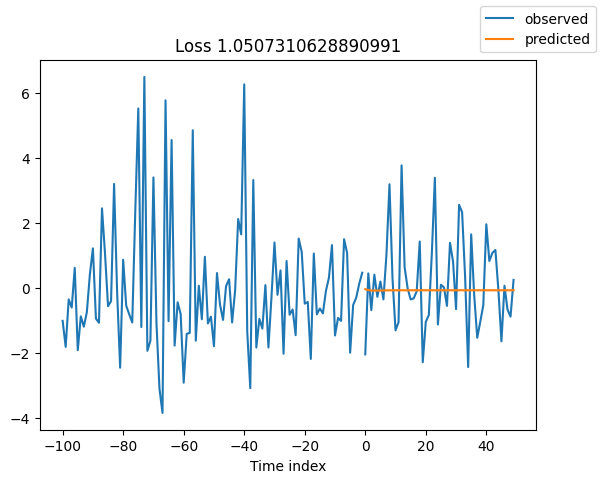

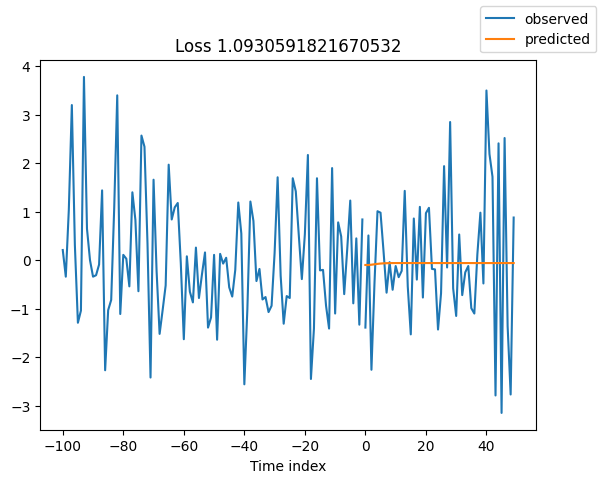

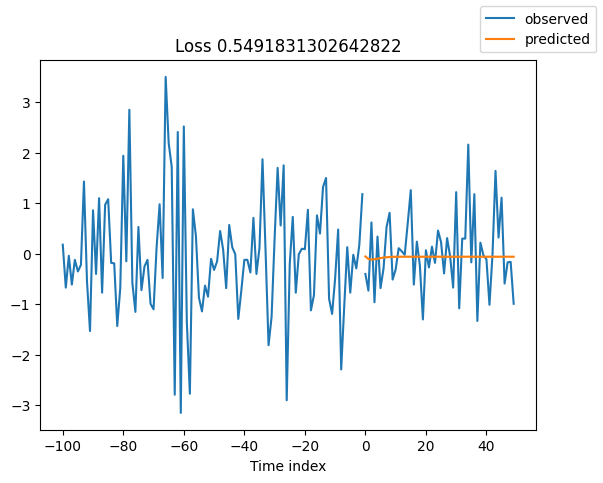

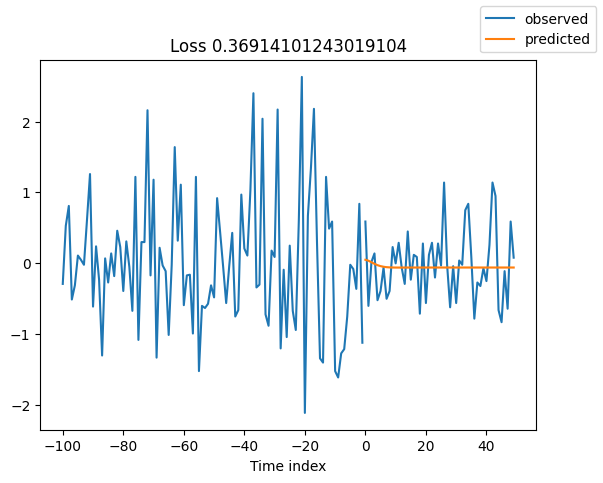

In [18]:
import numpy as np
for i in np.linspace(0, predictions.x['encoder_target'].shape[0]-1, 10, dtype=int):
    best_model.plot_prediction(predictions.x, predictions.output, idx=i, add_loss_to_title=True)